In [74]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14

In [173]:
# eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 50, 25, 40, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 1./10000
airind = mesh.gridCC[:,2]>0.
layerind1 = (np.logical_and(mesh.gridCC[:,2]<0, mesh.gridCC[:,2]>-500.))
layerind2 = (np.logical_and(mesh.gridCC[:,2]<-500, mesh.gridCC[:,2]>-800.))
layerind3 = (np.logical_and(mesh.gridCC[:,2]<-800, mesh.gridCC[:,2]>-1000.))

sigmaInf[airind] = 1e-8
sigmaInf[layerind1] = 1./5000
sigmaInf[layerind2] = 1./100.
sigmaInf[layerind3] = 1./10.
eta = np.zeros(mesh.nC)
eta1 = eta.copy()
eta[layerind3] = 0.2
eta1[layerind2] = 0.2
tau = np.ones(mesh.nC) * 0.1
c = np.ones(mesh.nC) * 0.5
wiresEM = Maps.Wires(('sigmaInf', mesh.nC), ('eta', mesh.nC), ('tau', mesh.nC), ('c', mesh.nC))
m0 = np.r_[sigmaInf, eta*0., tau, c]
m = np.r_[sigmaInf, eta, tau, c]
m1 = np.r_[sigmaInf, eta1, tau, c]

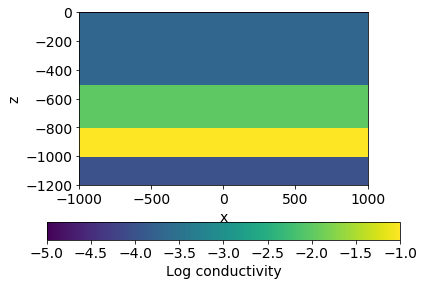

In [174]:
out = mesh.plotImage(np.log10(sigmaInf), grid=False, mirror=True, clim=(-5, -1))
plt.xlim(-1000, 1000)
plt.ylim(-1200, 0)
plt.gca().set_aspect('equal')
cb = plt.colorbar(out[0], orientation="horizontal")
plt.tight_layout()
cb.set_label("Log conductivity")

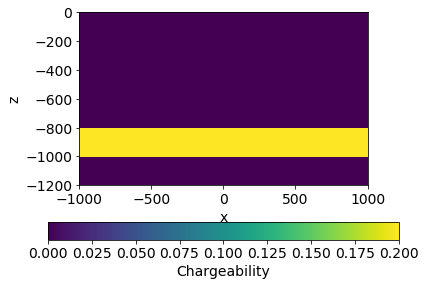

In [175]:
out = mesh.plotImage(eta, grid=False, mirror=True)
plt.xlim(-1000, 1000)
plt.ylim(-1200, 0)
plt.gca().set_aspect('equal')
cb = plt.colorbar(out[0], orientation="horizontal")
plt.tight_layout()
cb.set_label("Chargeability")

In [160]:
from simpegEMIP.TDEM import Problem3D_e, BaseTDEMIPProblem
from simpegEMIP.Base import BaseEMIPProblem

In [161]:
%%time
rxloc = np.array([[0., 0., 0.]])
srcloc = np.array([[0., 0., 0.]])
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(5e-4), 0, 41), 'z')

src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius=100.)
survey = EM.TDEM.Survey([src])
prb_emip = Problem3D_e(mesh, sigmaInfMap=wiresEM.sigmaInf, etaMap=wiresEM.eta, tauMap=wiresEM.tau, cMap=wiresEM.c)
# prb_emip.verbose = True
prb_emip.timeSteps = [(1e-04, 10), (5e-04, 10), (1e-03, 10), (5e-03, 10), (1e-02, 10), (5e-02, 10), (1e-01, 10)] 
prb_emip.Solver = PardisoSolver
prb_emip.pair(survey)
data = survey.dpred(m)

CPU times: user 16.8 s, sys: 293 ms, total: 17.1 s
Wall time: 10.6 s


In [162]:
dataInf = survey.dpred(m0)

In [176]:
data1 = survey.dpred(m1)

In [163]:
dataip = data-dataInf

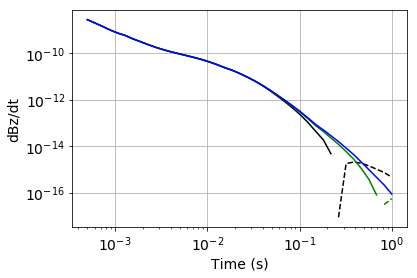

In [177]:
plt.loglog(rx.times, -data, 'k')
plt.loglog(rx.times, data, 'k--')
plt.loglog(rx.times, -data1, 'g')
plt.loglog(rx.times, data1, 'g--')

plt.loglog(rx.times, -dataInf, 'b')
plt.ylabel("dBz/dt")
plt.xlabel("Time (s)")
plt.grid(True)
# plt.loglog(rx.times, dataip, 'r')

In [165]:
dx, dy, dz = 100, 100, 20

In [166]:
alpha_s = 1./dx**2
alpha_x = 1. 
alpha_y = 1. 
alpha_z = (1./5)**2